Download DOGE data from [yahoo](https://finance.yahoo.com/quote/DOGE-USD/history?period1=1546300800&period2=1657756800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [5]:
# ticker_df_path = 'data/DOGE-USD.csv'
# ticker_df_path = 'data/BTC-USD.csv'
# ticker_df_path = 'data/TSLA.csv'
ticker_df_path = 'data/CNY=X.csv'

# tweets_df_path = 'data/elon_prepared_tweets.csv'
tweets_df_path = 'data/trump_prepared_tweets.csv'

In [6]:
ticker_df = pd.read_csv(ticker_df_path)
ticker_df.Date = pd.to_datetime(ticker_df.Date)
ticker_df.set_index('Date', drop=True, inplace=True)
ticker_df['NextDayClose'] = ticker_df.Close.shift(-1)
ticker_df = ticker_df.reindex(
    pd.date_range(
        '2019-01-01', 
        ticker_df.index.max()
    ),
    method='backfill',
)
ticker_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
2019-01-01,6.8776,6.8776,6.8730,6.8776,6.8776,0.0,6.8775
2019-01-02,6.8775,6.8785,6.8433,6.8775,6.8775,0.0,6.8611
2019-01-03,6.8611,6.8817,6.8611,6.8611,6.8611,0.0,6.8711
2019-01-04,6.8710,6.8710,6.8549,6.8711,6.8711,0.0,6.8684
2019-01-05,6.8684,6.8697,6.8396,6.8684,6.8684,0.0,6.8500


In [7]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1292 entries, 2019-01-01 to 2022-07-15
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1290 non-null   float64
 1   High          1290 non-null   float64
 2   Low           1290 non-null   float64
 3   Close         1290 non-null   float64
 4   Adj Close     1290 non-null   float64
 5   Volume        1290 non-null   float64
 6   NextDayClose  1289 non-null   float64
dtypes: float64(7)
memory usage: 80.8 KB


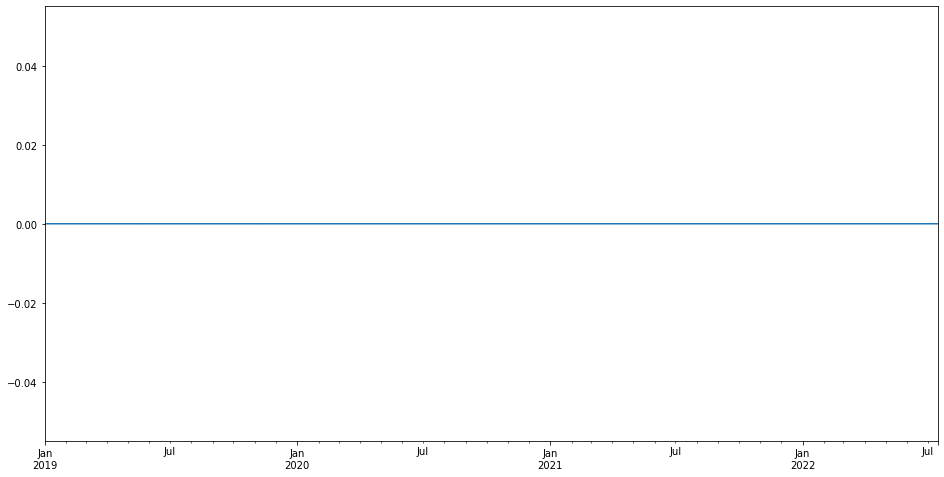

In [8]:
ticker_df.Volume.plot(figsize=(16, 8));

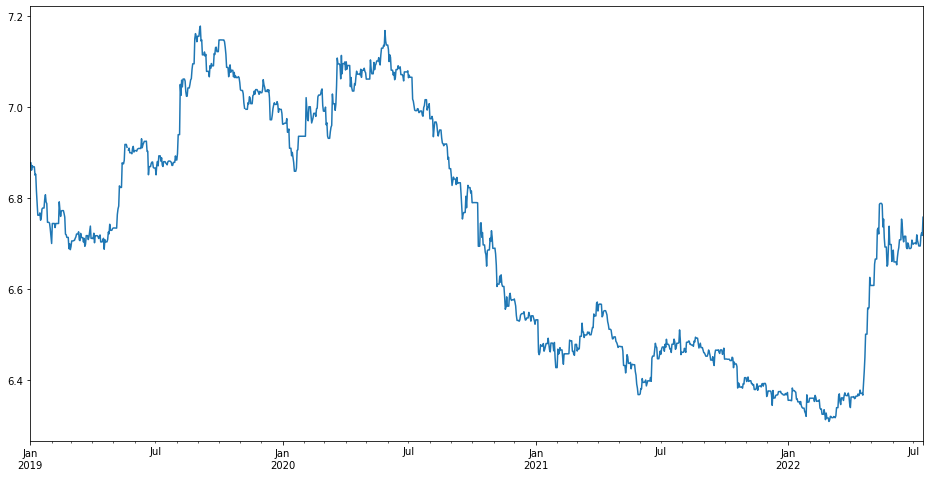

In [9]:
ticker_df.Close.plot(figsize=(16, 8));

In [10]:
tweets_df = pd.read_csv(tweets_df_path, index_col='id', parse_dates=['date'])
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
id,,,,,,,,,,,,,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,2020-03-03,i was thrilled to be back in the great city of...,-0.025369,0.013185,0.025902,0.013779,-0.020144,0.085133,-0.006004,...,0.055005,-0.022654,-0.032455,-0.001537,0.075067,0.033545,-0.043231,-0.002946,0.027171,0.038785
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,2020-01-17,rt read letter to surveillance court obtained ...,-0.147595,-0.055836,0.082966,0.016695,0.066793,0.136151,0.045195,...,0.058701,-0.063616,0.009711,-0.024108,0.090426,-0.083737,-0.044950,-0.058626,-0.031472,0.004875
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12,the unsolicited mail in ballot scam is a major...,0.009686,-0.055457,0.049761,0.053444,-0.045312,0.108593,-0.006554,...,0.023672,-0.045594,0.020217,-0.005316,0.058250,-0.091956,-0.111169,0.030698,0.045210,0.012122
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,2020-01-17,rt very friendly telling of events here about ...,-0.091189,-0.005541,-0.001080,0.007113,-0.039241,0.091224,-0.000484,...,0.054797,-0.031643,0.044863,-0.032381,0.018727,-0.135519,-0.089895,-0.002928,0.003388,0.023797
1217962723234983936,RT @WhiteHouse: President @realDonaldTrump ann...,2020-01-17,rt president announced historic steps to prote...,-0.014173,-0.064739,0.054706,-0.007583,-0.037187,0.064135,0.042061,...,0.062528,-0.075422,0.042154,0.042574,-0.001050,-0.067678,-0.079042,0.003974,-0.036825,0.043779


In [11]:
# tweets_df = tweets_df[tweets_df.cleared_text.str.contains('doge')]

In [12]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18649 entries, 1234653427789070336 to 1319345719829008384
Columns: 303 entries, text to V300
dtypes: datetime64[ns](1), float64(300), object(2)
memory usage: 43.3+ MB


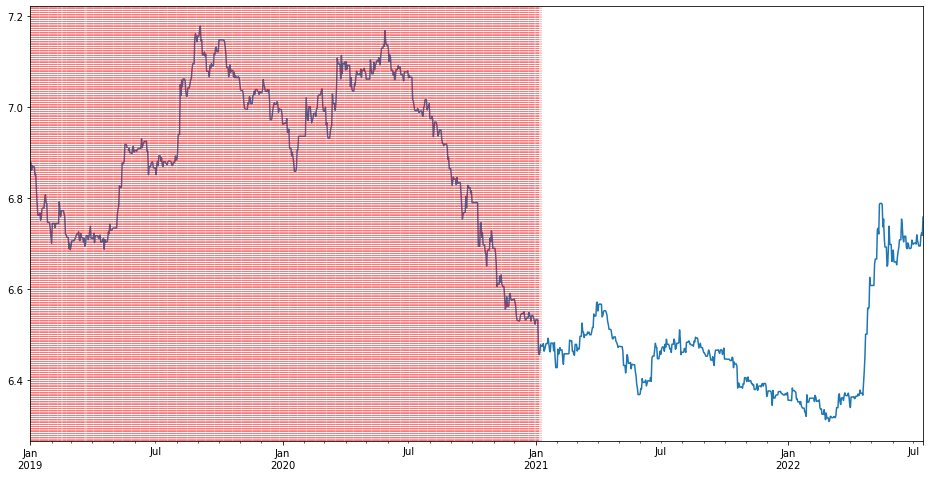

In [13]:
ticker_df.Close.plot(figsize=(16, 8));
for xc in set(tweets_df.date): # [tweets_df.cleared_text.str.contains('doge')]
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))

In [14]:
tweets_df['ticker_grow_in_this_day'] = tweets_df.apply(
    lambda r: ticker_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.Open > r.NextDayClose), 
    axis=1
)

In [15]:
tweets_df['ticker_grow_in_this_day'].mean()

0.4585768673923535

In [16]:
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V292,V293,V294,V295,V296,V297,V298,V299,V300,ticker_grow_in_this_day
id,,,,,,,,,,,,,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,2020-03-03,i was thrilled to be back in the great city of...,-0.025369,0.013185,0.025902,0.013779,-0.020144,0.085133,-0.006004,...,-0.022654,-0.032455,-0.001537,0.075067,0.033545,-0.043231,-0.002946,0.027171,0.038785,1
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,2020-01-17,rt read letter to surveillance court obtained ...,-0.147595,-0.055836,0.082966,0.016695,0.066793,0.136151,0.045195,...,-0.063616,0.009711,-0.024108,0.090426,-0.083737,-0.044950,-0.058626,-0.031472,0.004875,1
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,2020-09-12,the unsolicited mail in ballot scam is a major...,0.009686,-0.055457,0.049761,0.053444,-0.045312,0.108593,-0.006554,...,-0.045594,0.020217,-0.005316,0.058250,-0.091956,-0.111169,0.030698,0.045210,0.012122,1
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,2020-01-17,rt very friendly telling of events here about ...,-0.091189,-0.005541,-0.001080,0.007113,-0.039241,0.091224,-0.000484,...,-0.031643,0.044863,-0.032381,0.018727,-0.135519,-0.089895,-0.002928,0.003388,0.023797,1
1217962723234983936,RT @WhiteHouse: President @realDonaldTrump ann...,2020-01-17,rt president announced historic steps to prote...,-0.014173,-0.064739,0.054706,-0.007583,-0.037187,0.064135,0.042061,...,-0.075422,0.042154,0.042574,-0.001050,-0.067678,-0.079042,0.003974,-0.036825,0.043779,1


## TF-IDF. Logistic regression

In [17]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=500,
)

In [18]:
X = tfidf_vectorizer.fit_transform(tweets_df.cleared_text).toarray()
y = tweets_df.ticker_grow_in_this_day

len(tfidf_vectorizer.vocabulary_)

500

In [19]:
train_percent = 0.8
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16784, 500), (1865, 500), (16784,), (1865,))

In [20]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1010
           1       0.44      0.44      0.44       855

    accuracy                           0.49      1865
   macro avg       0.48      0.48      0.48      1865
weighted avg       0.49      0.49      0.49      1865



In [21]:
%%time
lin_regr = LogisticRegressionCV(
    cv=5,
    max_iter=5000,
    random_state=42,
    # scoring=lambda y_true, y_pred, *args: precision_score(1 - y_true, 1 - y_pred, *args),
    # scoring='precision',
    # class_weight='balanced',
    # multi_class='ovr',
).fit(X_train, y_train)

CPU times: user 2min 44s, sys: 1min 4s, total: 3min 49s
Wall time: 31.6 s


In [22]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.57      0.91      0.70      9087
           1       0.63      0.18      0.28      7697

    accuracy                           0.58     16784
   macro avg       0.60      0.55      0.49     16784
weighted avg       0.60      0.58      0.51     16784



In [23]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.55      0.91      0.69      1010
           1       0.56      0.14      0.22       855

    accuracy                           0.56      1865
   macro avg       0.56      0.52      0.46      1865
weighted avg       0.56      0.56      0.48      1865



In [24]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [25]:
lin_regr.intercept_

array([-0.15057944])

In [26]:
words_coeffs.sort_values(ascending=False).head(15)

national        0.564954
night           0.435440
biden           0.430711
police          0.384226
vote            0.322560
michigan        0.294200
trump           0.280729
pennsylvania    0.279830
deal            0.265165
mayor           0.258884
judge           0.254917
last night      0.238238
usmca           0.217267
fast            0.208721
taxes           0.203469
dtype: float64

In [27]:
words_coeffs.sort_values(ascending=True).head(15)

collusion    -0.484863
mueller      -0.413722
schiff       -0.397423
case         -0.396271
even         -0.377059
tariffs      -0.328514
day          -0.318833
mexico       -0.296028
amp          -0.290913
today        -0.277754
ohio         -0.250058
ever         -0.244167
corruption   -0.238435
house        -0.236380
fbi          -0.231600
dtype: float64

## TF-IDF. Random forest

In [28]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [29]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9087
           1       0.97      0.91      0.94      7697

    accuracy                           0.94     16784
   macro avg       0.95      0.94      0.94     16784
weighted avg       0.94      0.94      0.94     16784



In [30]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.57      0.65      0.60      1010
           1       0.50      0.41      0.45       855

    accuracy                           0.54      1865
   macro avg       0.53      0.53      0.53      1865
weighted avg       0.54      0.54      0.53      1865



In [31]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [32]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 13.2 s, sys: 255 ms, total: 13.4 s
Wall time: 5min 7s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [33]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      9087
           1       0.83      0.05      0.10      7697

    accuracy                           0.56     16784
   macro avg       0.69      0.52      0.40     16784
weighted avg       0.68      0.56      0.43     16784



In [34]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.54      0.98      0.70      1010
           1       0.54      0.02      0.05       855

    accuracy                           0.54      1865
   macro avg       0.54      0.50      0.37      1865
weighted avg       0.54      0.54      0.40      1865



In [35]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [36]:
words_importances.sort_values(ascending=False).head(15)

national      0.031759
night         0.030660
collusion     0.026287
biden         0.024813
mueller       0.023732
trump         0.016853
tariffs       0.015557
case          0.015370
schiff        0.014801
vote          0.012691
last night    0.012336
police        0.010343
ohio          0.010281
even          0.009971
amp           0.009457
dtype: float64

In [37]:
words_importances.sort_values(ascending=True).head(15)

approval rating    0.000052
israel             0.000076
testing            0.000085
secretary          0.000116
rate               0.000123
stock              0.000130
four               0.000141
rating             0.000143
without            0.000144
companies          0.000168
signed             0.000175
families           0.000181
action             0.000182
winning            0.000186
used               0.000187
dtype: float64